In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU, AUC

import warnings
warnings.filterwarnings("ignore")

In [2]:
DIR = '/kaggle/input/bangladeshi-fish-species/Bangladeshi Fish Species Identification Dataset/Resized'
classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['Shorputi',
 'Foli',
 'Tengra',
 'KalBaush',
 'Pabda',
 'Aair',
 'Koi',
 'DeshiPuti',
 'Pangas',
 'Rui',
 'Magur',
 'Tarabaim',
 'Ilish',
 'Telapiya',
 'Puti',
 'Shol',
 'Taki',
 'Chapila',
 'Katla',
 'Boal',
 'Mrigel']

In [3]:
label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.jpg':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [4]:
df['label'].value_counts()

label
Rui          2726
Taki         2223
Telapiya     2058
Mrigel       1808
Aair         1804
Katla        1765
Pabda        1764
Boal         1651
Puti         1560
Tengra       1431
Shol         1424
Tarabaim     1262
Ilish        1031
Pangas        934
KalBaush      917
Koi           842
Magur         574
Foli          562
Chapila       428
DeshiPuti     412
Shorputi       44
Name: count, dtype: int64

In [5]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [6]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)

Found 17421 validated image filenames belonging to 21 classes.
Found 4355 validated image filenames belonging to 21 classes.
Found 5444 validated image filenames belonging to 21 classes.


In [7]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Shorputi': 16,
 'Taki': 17,
 'Tarabaim': 18,
 'Telapiya': 19,
 'Tengra': 20}

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Shorputi': 16,
 'Taki': 17,
 'Tarabaim': 18,
 'Telapiya': 19,
 'Tengra': 20}

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Shorputi': 16,
 'Taki': 17,
 'Tarabaim': 18,
 'Telapiya': 19,
 'Tengra': 20}

In [8]:
pretrained_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # Global average pooling
)

pretrained_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
inputs = pretrained_model.input
x = layers.Dense(128, activation='relu')(pretrained_model.output)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(21, activation='softmax')(x)  # Assuming 20 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,142,973 (80.65 MB)

 Trainable params: 281,493 (1.07 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 2187s 4s/step - accuracy: 0.6886 - loss: 1.0737 - val_accuracy: 0.9341 - val_loss: 0.2049
Epoch 2/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 2170s 4s/step - accuracy: 0.9510 - loss: 0.1537 - val_accuracy: 0.9481 - val_loss: 0.1638
Epoch 3/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 2164s 4s/step - accuracy: 0.9742 - loss: 0.0884 - val_accuracy: 0.9612 - val_loss: 0.1280
Epoch 4/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 2312s 4s/step - accuracy: 0.9803 - loss: 0.0590 - val_accuracy: 0.9571 - val_loss: 0.1338
Epoch 5/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 2292s 4s/step - accuracy: 0.9895 - loss: 0.0334 - val_accuracy: 0.9734 - val_loss: 0.0859


In [10]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Loss: 0.08217
Test Accuracy: 97.23%


171/171 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step
Accuracy Score: 0.9722630418809699
              precision    recall  f1-score   support

        Aair       0.98      0.96      0.97       361
        Boal       0.94      0.99      0.96       333
     Chapila       0.98      0.99      0.98        83
   DeshiPuti       0.99      0.98      0.98        87
        Foli       0.98      0.90      0.94       108
       Ilish       0.99      0.99      0.99       185
    KalBaush       0.96      0.93      0.94       211
       Katla       0.97      0.94      0.96       344
         Koi       1.00      0.99      1.00       158
       Magur       0.99      0.99      0.99       110
      Mrigel       0.97      0.97      0.97       351
       Pabda       0.97      1.00      0.99       348
      Pangas       0.99      1.00      1.00       208
        Puti       0.98      0.98      0.98       284
         Rui       0.95      0.97      0.96       578
        Shol       0.94      1.00      0.97       278
    

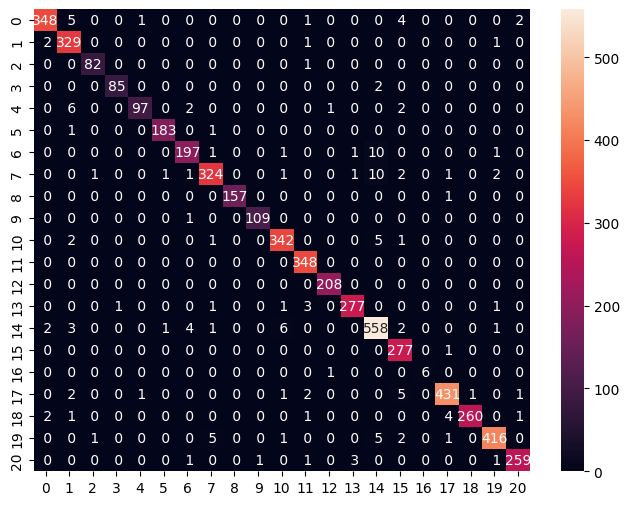

In [11]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
pred_df = test_df.copy()
labels = {v: k for k, v in test_images.class_indices.items()}
pred_df['pred'] = pred
pred_df['pred'] = pred_df['pred'].apply(lambda x: labels[x])

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(pred_df['label'], pred_df['pred'])}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(pred_df['label'], pred_df['pred']), annot=True, fmt='2d')

# Print classification report
print(classification_report(pred_df['label'], pred_df['pred']))

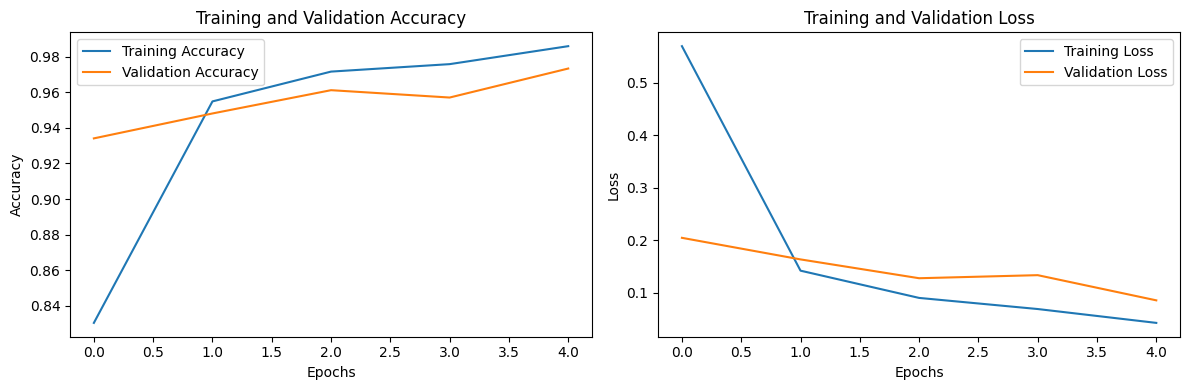

In [12]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Check if 'accuracy' and 'val_accuracy' are available in the history (depends on Keras version)
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Check if 'loss' and 'val_loss' are available in the history
if 'loss' in history.history and 'val_loss' in history.history:
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()
